In [1]:
import os, time, errno
import torch, tables
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
os.environ['CUDA_VISIBLE_DEVICES']='2'
savedir = '32x32-convnet-scrambled-both'

In [3]:
T = 10 # time buckets

hdf5 = tables.open_file('captures/fei/R1_E3_AMES_200min_200f_14l_rgb.h5','r')
hdf5 = hdf5.root

try:
    dataset = np.load('captures/fei/cache.npy')
except FileNotFoundError:

    data = []
    for i in range(7):
        print('.',end='')
        batch = np.array(hdf5['data'][i*400:(i+1)*400])
        batch = batch.reshape(-1,T,int(batch.shape[1]/T),64,64,6).sum(2).astype(np.float32) # binning
        data.append(batch)
        
    dataset = np.concatenate(data,axis=0)
    dataset = np.moveaxis(dataset,[0,1,2,3,4],[0,1,3,4,2])
    np.save('captures/fei/cache.npy', dataset)
    
classes = np.array([np.array(itm.decode('utf-8').split('"'))[[1,3]].astype(np.int32)
                    for itm in np.array(hdf5['image_classes'].read())])

# Presented targets

In [4]:
imgs = hdf5["images"][0:100]
y,x = np.where(np.mean(imgs, axis=(0,3))>5)
xleft, xright, ytop, ybot = min(x), max(x), min(y), max(y)

images = hdf5["images"][:,ytop:ybot,xleft:xright]

tiny_images = []
for i in range(len(images)):
    tiny_images.append(cv2.resize(images[i],(64,64)))
images = np.stack(tiny_images)

# Model

In [5]:
class Block(torch.nn.Module):
    def __init__(self, filters):
        super(Block, self).__init__()
        
        self.block = torch.nn.Sequential(
            torch.nn.Conv2d(filters, filters, 3, padding=1, bias=False),
            torch.nn.BatchNorm2d(filters), torch.nn.ReLU(),
            torch.nn.Conv2d(filters, filters, 3, padding=1, bias=False),
            torch.nn.BatchNorm2d(filters))
        
    def forward(self, x):
        return F.relu(x + self.block(x))
    
class ConvNet(torch.nn.Module):
    def __init__(self, filters=512):
        super(ConvNet, self).__init__()
        self.filters = filters
        
        self.conv_in = torch.nn.Conv2d(10*6, filters, 9, padding=4, stride=4, bias=False)
        
        self.resnet = torch.nn.ModuleList()
        for i in range(101): self.resnet.append(Block(filters))
            
        self.conv_out =  torch.nn.ConvTranspose2d(self.filters, 1, 8, stride=8, bias=True)
        self.bias = torch.nn.Parameter(torch.Tensor(64,64))
        
        for name, parm in self.named_parameters():
            if name.endswith('weight'): torch.nn.init.normal_(parm, 0, .01)
            if name.endswith('bias'): torch.nn.init.constant_(parm, 0.0)
    
    def forward(self, x):
        x = x.view(-1,10*6,64,64)[:,:,::2,::2].contiguous()
        zx = F.relu(self.conv_in(x))
        for layer in self.resnet: zx = layer(zx)
        return torch.sigmoid(self.conv_out(zx).squeeze() + self.bias[None,:,:])

# Fit

In [6]:
data = torch.tensor(dataset)/30. # scaling
targets = torch.tensor(images).float().mean(3)/255.
order = np.random.permutation(range(64*64))

In [7]:
train_data = data[[i for i in range(2800) if (i+1)%5 != 0]]
val_data = data[slice(4,2800,10)]
test_data = data[slice(9,2800,10)]

train_targets = targets[[i for i in range(2800) if (i+1)%5 != 0]]
val_targets = targets[slice(4,2800,10)]
test_targets = targets[slice(9,2800,10)]

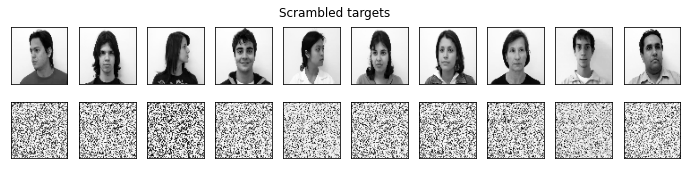

In [8]:
fig, ax = plt.subplots(2,10, figsize=(12,2.5))
fig.suptitle('Scrambled targets')

for i in range(10):
    ax[0,i].imshow(train_targets[i],cmap='Greys_r')
    ax[0,i].set_xticks([]); ax[0,i].set_yticks([])
    
    ax[1,i].imshow(train_targets[i].view(-1)[order].view(64,64),cmap='Greys_r')
    ax[1,i].set_xticks([]); ax[1,i].set_yticks([])
    
train_targets = train_targets.view(-1,64*64)[:,order].view(-1,64,64)
val_targets = val_targets.view(-1,64*64)[:,order].view(-1,64,64)
test_targets = test_targets.view(-1,64*64)[:,order].view(-1,64,64)

train_data = train_data.contiguous().view(-1,64*64)[:,order].view(-1,10,6,64,64)
val_data = val_data.contiguous().view(-1,64*64)[:,order].view(-1,10,6,64,64)
test_data = test_data.contiguous().view(-1,64*64)[:,order].view(-1,10,6,64,64)

In [9]:
batch_size = 8

model = ConvNet().cuda()
count = sum([np.prod(parm.shape) for parm in model.parameters() if parm.requires_grad])
print('Initialized a graph with {} parameters'.format(count))

train_history = []
val_history = []

model.eval()
loss = 0.
for i in np.random.permutation(len(val_data)//batch_size):
    start, end = i*batch_size, (i+1)*batch_size
    x,z = val_data[start:end].cuda(), val_targets[start:end].cuda()
    loss += ((model(x).detach() - z)**2).sum(1).mean()
val_history.append(loss/(len(val_data)//batch_size))
print('Initial Loss: {:2f}'.format(val_history[-1]))

Initialized a graph with 479309825 parameters
Initial Loss: 4.071687


In [10]:
batch_size = 8
optimizer = torch.optim.Adam(model.parameters(), lr=.0003)

try:
    print('epoch\ttrain loss\ttest loss\ttime\t\tutime')
    t0 = time.time()
    for epoch in range(500):
        model.train()
        loss_train = 0
        for i in np.random.permutation(len(train_data)//batch_size):
            start, end = i*batch_size, (i+1)*batch_size
            x,z = train_data[start:end].cuda(), train_targets[start:end].cuda()
            loss = ((model(x) - z)**2).sum(1).mean()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.detach()
        train_history.append(loss_train/(len(train_data)//batch_size))

        if epoch % 1 == 0:
            t1 = time.time()
            model.eval()
            loss = 0.
            for i in range(len(val_data)//batch_size):
                start, end = i*batch_size, (i+1)*batch_size
                x,z = val_data[start:end].cuda(), val_targets[start:end].cuda()
                loss += ((model(x).detach() - z)**2).sum(1).mean()
            val_history.append(loss/(len(val_data)//batch_size))
            print('{:d}\t{:2f}\t{:2f}\t{:2f}\t{:2f}'.format(epoch,train_history[-1],val_history[-1],time.time()-t0, time.time()-t1))
            t0 = time.time()
            
except KeyboardInterrupt:
    print('Graceful Exit')
else:
    print('Finished')

epoch	train loss	test loss	time		utime
0	1.501328	1.629486	84.058993	2.245141
1	1.309588	1.785084	88.910134	2.334376
2	1.252553	2.706551	89.586187	2.348696
3	1.180612	1.875571	89.749363	2.348324
4	1.132245	1.640318	89.767551	2.343311
5	1.099824	1.519336	89.841564	2.335316
6	1.097327	1.823478	89.794415	2.356763
7	1.078740	1.601026	89.991915	2.335450
8	1.065619	1.798398	89.757342	2.348576
9	1.051885	1.653879	89.610201	2.334754
10	1.039589	1.574389	89.635244	2.334744
11	1.033356	1.723009	89.497992	2.345279
12	1.028479	1.582542	89.516530	2.342661
13	1.018850	1.599798	89.496832	2.335808
14	1.003025	1.863734	89.462844	2.336129
15	0.972190	1.659942	89.501555	2.334750
16	0.921685	1.702720	89.379271	2.334752
17	0.864929	1.830715	89.437305	2.335615
18	0.806541	1.424310	89.379094	2.332800
19	0.747126	1.420481	89.421314	2.332269
20	0.706788	1.358407	89.464657	2.340570
21	0.667729	1.342364	89.506626	2.333499
22	0.634193	1.639110	89.394784	2.337893
23	0.604113	1.419528	89.437574	2.340795
24	0.581740

202	0.011926	1.210859	89.782554	2.341589
203	0.012938	1.305626	89.728346	2.340212
204	0.012712	1.147389	89.675843	2.342157
205	0.011591	1.124430	89.702410	2.343190
206	0.010081	1.209113	89.666511	2.342951
207	0.009212	1.112450	89.710150	2.343963
208	0.009615	1.090664	89.581724	2.341184
209	0.010065	1.064169	89.743733	2.343486
210	0.010414	1.136626	89.660192	2.341450
211	0.010439	1.060644	89.695523	2.342076
212	0.010633	1.239662	89.708662	2.331245
213	0.010584	1.115459	89.761974	2.343496
214	0.010852	1.140660	89.680366	2.341398
215	0.010865	1.121415	89.738005	2.328643
216	0.010634	1.059532	89.767780	2.340458
217	0.009612	1.170440	89.730307	2.342665
218	0.009345	1.147157	89.691354	2.336510
219	0.008897	1.064293	89.767119	2.341702
220	0.009113	1.079765	89.743268	2.328935
221	0.009829	1.169447	89.720434	2.342511
222	0.010694	1.140066	89.752495	2.340246
223	0.011294	1.037177	89.757088	2.341485
224	0.010364	1.106072	89.713896	2.342342
225	0.009286	1.090006	89.760520	2.336061
226	0.008049	1.0

402	0.004575	1.193619	89.420657	2.335571
403	0.004580	1.173709	89.365410	2.342444
404	0.004819	1.208325	89.521425	2.342700
405	0.004794	1.252773	89.459590	2.332099
406	0.004668	1.155319	89.349455	2.342232
407	0.004317	1.106036	89.357998	2.331748
408	0.004044	1.124390	89.441560	2.327049
409	0.003706	1.196436	89.264638	2.330631
410	0.003884	1.303101	89.450870	2.336898
411	0.004150	1.191977	89.447838	2.340926
412	0.004298	1.250776	89.445560	2.329378
413	0.004435	1.299014	89.414542	2.342099
414	0.004582	1.150065	89.459635	2.341635
415	0.004700	1.243643	89.399053	2.341068
416	0.004535	1.277923	89.444880	2.340537
417	0.003900	1.051849	89.519467	2.342073
418	0.003607	1.281273	89.458699	2.341545
419	0.003510	1.136489	89.382996	2.343554
420	0.003662	1.126306	89.346016	2.330463
421	0.003947	1.099532	89.356268	2.340559
422	0.004441	1.342629	89.447306	2.340992
423	0.004631	1.164716	89.441988	2.343863
424	0.004582	1.184224	89.360042	2.330397
425	0.004332	1.033068	89.370053	2.341270
426	0.004203	1.0

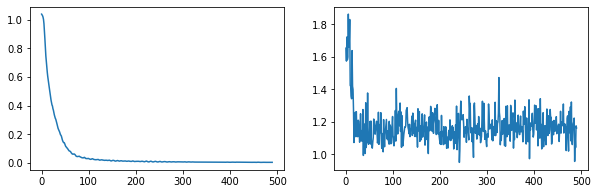

In [11]:
fig, ax = plt.subplots(1,2, figsize=(10,3))

ax[0].plot(train_history[10:])
ax[1].plot(val_history[10:])

In [12]:
model.eval()
loss = 0.
for i in np.random.permutation(len(test_data)//batch_size):
    start, end = i*batch_size, (i+1)*batch_size
    x,z = test_data[start:end].cuda(), test_targets[start:end].cuda()
    loss += ((model(x).detach() - z)**2).view(-1,64*64).sum(1).mean()
print('Final Loss: {:2f}'.format(loss/(len(test_data)//batch_size)))

Final Loss: 72.205032


In [13]:
invorder = np.array(sorted(zip(range(64*64),order),key=lambda x: x[1]))[:,0]

In [14]:
try:
    os.makedirs(f'final-outputs/{savedir}')
except OSError as e:
    if e.errno != errno.EEXIST:
        raise

originals = False
try:
    os.makedirs('final-outputs/scrambled-targets')
except OSError as e:
    if e.errno != errno.EEXIST:
        raise
    originals = True

train_idx = 0
val_idx = 0
test_idx = 0
for i in range(len(data)):
    person, pose = classes[i]
    if (i+1) % 5 != 0: # training data
        prefix = f'train{train_idx}'
        train_idx += 1
    elif (i+1) % 10 == 5: # validation data
        prefix = f'valid{val_idx}'
        val_idx += 1
    else: # (i+1) % 10 == 0 (test data)
        prefix = f'test{test_idx}'
        test_idx += 1
    
    recon = model(data[i].view(-1,64*64)[:,order].view(10,6,64,64).cuda()).detach().cpu()[0]
    recon = recon.view(64*64)[invorder].view(64,64).numpy() # descramble
    cv2.imwrite(f'final-outputs/{savedir}/{prefix}-person{person}-pose{pose}.png', 255*recon)
    if not originals:
        target = targets[i].view(64*64)[order].view(64,64).numpy() # scramble
        cv2.imwrite(f'final-outputs/scrambled-targets/{prefix}-person{person}-pose{pose}.png', 255*target)

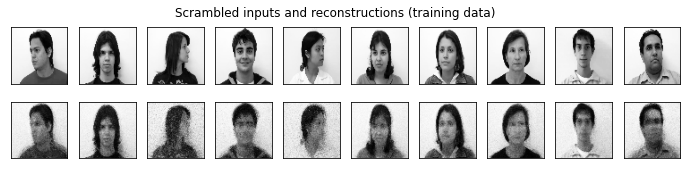

In [15]:
fig, ax = plt.subplots(2,10, figsize=(12,2.5))
fig.suptitle('Scrambled inputs and reconstructions (training data)')

model.eval()
reconstructions = model(train_data[0:10].cuda()).detach().cpu()
for i in range(10):
    ax[0,i].imshow(train_targets[i].view(64*64)[invorder].view(64,64),cmap='Greys_r')
    ax[0,i].set_xticks([]); ax[0,i].set_yticks([])
    
    ax[1,i].imshow(reconstructions[i].view(64*64)[invorder].view(64,64),cmap='Greys_r')
    ax[1,i].set_xticks([]); ax[1,i].set_yticks([])

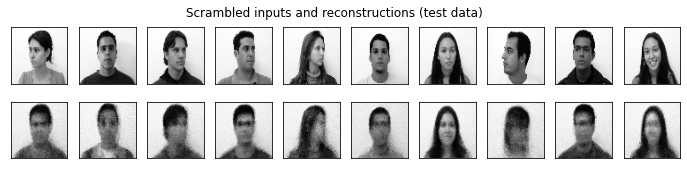

In [16]:
fig, ax = plt.subplots(2,10, figsize=(12,2.5))
fig.suptitle('Scrambled inputs and reconstructions (test data)')

model.eval()
reconstructions = model(test_data[0:10].cuda()).detach().cpu()
for i in range(10):    
    ax[0,i].imshow(test_targets[i].view(64*64)[invorder].view(64,64),cmap='Greys_r')
    ax[0,i].set_xticks([]); ax[0,i].set_yticks([])
    
    ax[1,i].imshow(reconstructions[i].view(64*64)[invorder].view(64,64),cmap='Greys_r')
    ax[1,i].set_xticks([]); ax[1,i].set_yticks([])